# $H_2$ PES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [ ]:
%cd drive/MyDrive/chem_ML/
!ls

/content/drive/MyDrive/chem_ML
CH3ClF.xyz		  FCl_Sn2.npz	M1_50_2.npz    M2_50_torch
Cl-F.npz		  H2PES.npy	M1_50.npz      M4_100.npz
FCH3Cl.xyz		  H2PES.txt	M1_50_torch    M4_100_torch
FCl_internal.npz	  M1_100.npz	M1_50_torch_1  M4_50.npz
F-Cl.npz		  M1_100_torch	M1_50_torch_2  M4_50_torch
FCl_path_E.txt		  M1_200.npz	M2_200.npz     new_Cl_F_coord.npz
FCl_pathway_internal.npz  M1_200_torch	M2_200_torch   sn2_reactions.npz
FCl_pathway.npz		  M1_50_1.npz	M2_50.npz


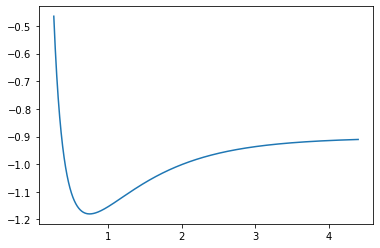

In [ ]:
H2PES = np.load('H2PES.npy')
plt.plot(H2PES[1:,0], H2PES[1:,1])

In [ ]:
# idx = np.sort(np.random.randint(0,H2PES.shape[0],(200,)))
idx = np.arange(0,H2PES.shape[0],10)
X_train = H2PES[idx,0]
y_train = H2PES[idx,1]

Train size: 84


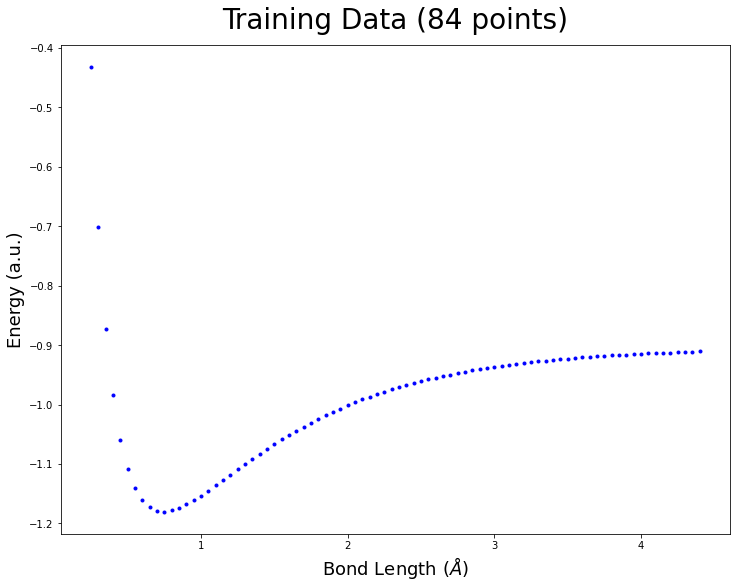

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(X_train,y_train,ls='',marker='.',c='b',lw=2)
plt.ylabel('Energy (a.u.)',fontsize=18)
plt.xlabel(r'Bond Length ($\AA$)',fontsize=18)
plt.title(f'Training Data ({idx.size} points)',fontsize=28,y=1.02)
print('Train size:', idx.size)

In [ ]:
class Single_Hidden(nn.Module):
  # Contructor
  def __init__(self, in_size=1, hidden=100, out_size=1):
    super(Single_Hidden, self).__init__()
    self.L_hide = nn.Linear(in_size, hidden)
    self.L_out = nn.Linear(hidden, out_size)
    
  # Activation
  def forward(self, x):
    f = nn.Softplus()
    x = f(self.L_hide(x))
    x = self.L_out(x)
    return x


In [ ]:
def train(model, x, y, criterion, optimizer, epochs=5000):
  cost=np.zeros(epochs)
  for epoch in range(epochs):
    total = 0
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat,y)
    loss.backward()
    optimizer.step()
    cost[epoch] = loss.item()
  return cost

In [ ]:
y_pred = []
Cost = []
new_X = torch.from_numpy(H2PES[:,0]).view(-1,1).float()
X = torch.from_numpy(X_train).view(-1,1).float()
Y = torch.from_numpy(y_train).view(-1,1).float()
for i in range(2,6):
  
  torch.manual_seed(i+5)
  learning_rate = 0.1
  model = Single_Hidden(1,i,1)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  cost_arr = train(model, X, Y, criterion, optimizer, 1148)
  y_pred.append(model(new_X).detach().numpy().reshape(H2PES.shape[0],))
  Cost.append(cost_arr)
  print(i, cost_arr[-1])


2 0.010862689465284348
3 0.007434417959302664
4 0.00032339239260181785
5 4.9285175919067115e-05


53.768948051285
35.305298541392844
7.785100040121638
3.1556008163204856


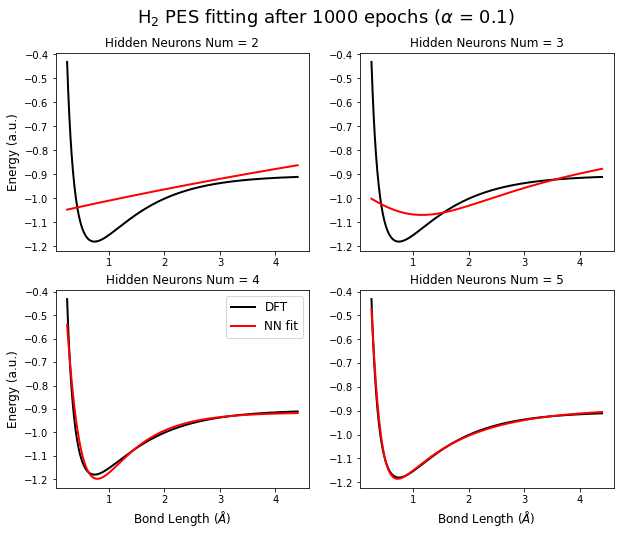

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
for i in range(4):
  ax[i//2,i%2].plot(H2PES[:,0],H2PES[:,1],c='k',lw=2,label='DFT')
  ax[i//2,i%2].plot(H2PES[:,0],y_pred[i],c='r',lw=2,label='NN fit')
  ax[i//2,i%2].set_title(f'Hidden Neurons Num = {i+2}')
  print(np.sum(np.abs(y_pred[i]-H2PES[:,1])))
for i in range(2): ax[i,0].set_ylabel('Energy (a.u.)',fontsize=12)
for i in range(2): ax[1,i].set_xlabel(r'Bond Length ($\AA$)',fontsize=12)
fig.suptitle(r'H$_2$ PES fitting after 1000 epochs ($\alpha$ = 0.1)',y=0.96,fontsize=18)
ax[1,0].legend(fontsize=12)

Text(0, 0.5, 'Cost')

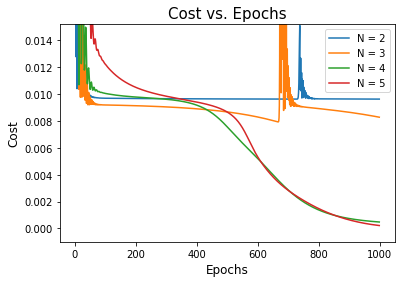

In [ ]:
plt.figure(figsize=(6,4))
for i in range(4):
  plt.plot(Cost[i][:1000],label=f'N = {i+2}')
plt.ylim([-0.001,0.0152])
plt.legend()
plt.title('Cost vs. Epochs',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Cost',fontsize=12)

# Cl-F $S_N$2

In [ ]:
data_FCl = np.load("FCl_internal.npz",allow_pickle=True)
for key in data_FCl.keys():
  print(key, data_FCl[key].shape)


E (44501,)
R (44501, 15)


In [ ]:
E_mu = data_FCl['E'].mean()
E_std = data_FCl['E'].std()
E_rvs = (data_FCl['E'] - E_mu) / E_std

In [ ]:
train_idx = np.random.choice(E_rvs.size,(80*512,),replace=False)
test_idx = np.setdiff1d(np.arange(E_rvs.size),train_idx)
print(train_idx.shape)
print(test_idx.shape)

(40960,)
(3541,)


In [ ]:
pw_int = np.load('FCl_pathway_internal.npz',allow_pickle=True)

plt.figure(figsize=(25,25))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Dataset Distribution',fontsize=50,y=1.02)
plt.xlabel(r'C-F Bond Length ($\AA$)',fontsize=35)
plt.ylabel(r'C-Cl Bond Length ($\AA$)',fontsize=35)
plt.plot(data_FCl['R'][train_idx,3],data_FCl['R'][train_idx,4],ls='',marker='.',lw=0.01,c='lightgreen',label='Training Set')
plt.plot(data_FCl['R'][test_idx,3],data_FCl['R'][test_idx,4],ls='',marker='.',lw=0.01,c='green',label='Validation Set')
plt.plot(pw_int['R'][:,3],pw_int['R'][:,4],ls='',marker='*',lw=5,c='r',label='Reaction Pathway')
plt.legend(fontsize=35)

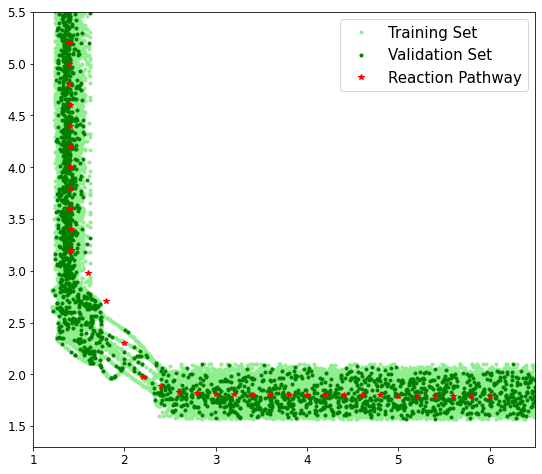

In [ ]:
pw_int = np.load('FCl_pathway_internal.npz',allow_pickle=True)

plt.figure(figsize=(9,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([1,6.5]); plt.ylim([1.3,5.5])
#plt.title('Dataset Distribution',fontsize=20,y=1.02)
#plt.xlabel(r'C-F Bond Length ($\AA$)',fontsize=15)
#plt.ylabel(r'C-Cl Bond Length ($\AA$)',fontsize=15)
plt.plot(data_FCl['R'][train_idx,3],data_FCl['R'][train_idx,4],ls='',marker='.',lw=0.01,c='lightgreen',label='Training Set')
plt.plot(data_FCl['R'][test_idx,3],data_FCl['R'][test_idx,4],ls='',marker='.',lw=0.01,c='green',label='Validation Set')
plt.plot(pw_int['R'][:,3],pw_int['R'][:,4],ls='',marker='*',lw=5,c='r',label='Reaction Pathway')
plt.legend(fontsize=15)

In [ ]:
train_X = torch.from_numpy(data_FCl['R'][train_idx]).view(-1,15).float()
train_y = torch.from_numpy(E_rvs[train_idx]).view(-1,1).float()
test_X = torch.from_numpy(data_FCl['R'][test_idx]).view(-1,15).float()
test_y = torch.from_numpy(E_rvs[test_idx]).view(-1,1).float()
print(train_X.shape,test_y.shape)

torch.Size([40960, 15]) torch.Size([3541, 1])


In [ ]:
class Single_Hidden(nn.Module):
  # Contructor
  def __init__(self, in_size=15, hidden=100, out_size=1):
    super(Single_Hidden, self).__init__()
    self.L_hide = nn.Linear(in_size, hidden)
    self.L_out = nn.Linear(hidden, out_size)
    
  # Prediction
  def forward(self, x):
    f = nn.Softplus()
    x = f(self.L_hide(x))
    x = self.L_out(x)
    return x

def batch_train(model, x, y, criterion, optimizer, batches, batch_size):
  batch_costs = np.zeros(batches)
  for b in range(batches):    
    optimizer.zero_grad()
    yhat = model(x[b*batch_size:(b+1)*batch_size])
    loss = criterion(yhat,y[b*batch_size:(b+1)*batch_size])
    loss.backward()
    optimizer.step()
    batch_costs[b] = loss.item()
  return batch_costs

In [ ]:
torch.manual_seed(9)
learning_rate = 0.1
epochs = 120
model_1_50 = Single_Hidden(15,50,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_50.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs)
for e in range(epochs):
  cost_arr = batch_train(model_1_50, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  cross_val[e] = criterion(model_1_50(test_X),test_y).detach().numpy()
np.savez('M1_50',C=total_cost,V=cross_val)
torch.save(model_1_50,'M1_50_torch')

In [ ]:
torch.manual_seed(9)
learning_rate = 0.02
epochs = 120
model_1_50 = Single_Hidden(15,50,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_50.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs)
for e in range(epochs):
  cost_arr = batch_train(model_1_50, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  cross_val[e] = criterion(model_1_50(test_X),test_y).detach().numpy()
np.savez('M1_50_1',C=total_cost,V=cross_val)
torch.save(model_1_50,'M1_50_torch_1')

26.46139293909073
0.3212144374847412


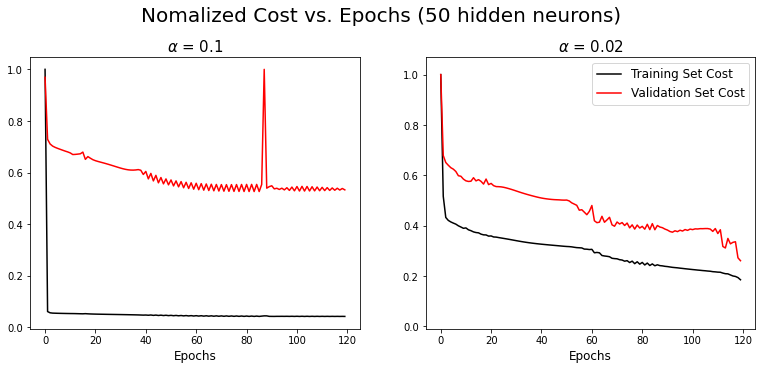

In [ ]:
result1 = np.load('M1_50.npz',allow_pickle=True)
result2 = np.load('M1_50_1.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle('Nomalized Cost vs. Epochs (50 hidden neurons)',fontsize=20,y=1.02)
ax[0].plot(result1['C']/result1['C'].max(),c='k')
ax[0].plot(result1['V']/result1['V'].max(),c='r')
ax[0].set_title(r'$\alpha$ = 0.1',fontsize=15)
ax[0].set_xlabel('Epochs',fontsize=12)

ax[1].plot(result2['C']/result2['C'].max(),c='k',label='Training Set Cost')
ax[1].plot(result2['V']/result2['V'].max(),c='r',label='Validation Set Cost')
ax[1].set_title(r'$\alpha$ = 0.02',fontsize=15)
ax[1].set_xlabel('Epochs',fontsize=12)
ax[1].set_ylim([-0.01,1.07])
ax[1].legend(fontsize=12)
print(result1['C'][-1])
print(result1['V'][-1])


In [ ]:
torch.manual_seed(9)
learning_rate = 0.015
epochs = 980
model_1_50 = Single_Hidden(15,50,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_50.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_1_50, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_1_50(test_X),test_y).detach().numpy()
np.savez('M1_50_2',C=total_cost,V=cross_val)
torch.save(model_1_50,'M1_50_torch_2')

2.083643041551113
0.027413468807935715
-28.752287 0.0008915649


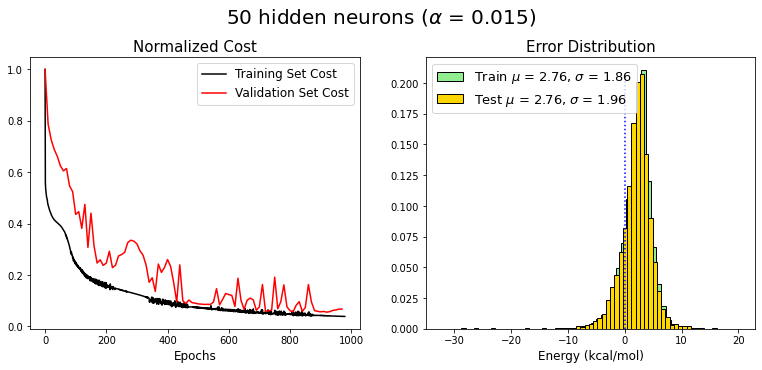

In [ ]:
result = np.load('M1_50_2.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'50 hidden neurons ($\alpha$ = 0.015)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M1_50_torch_2')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))

ax[1].legend(fontsize=13)
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.21,ls=':',color='b')
print(kcal.min(),q.min())


In [ ]:
torch.manual_seed(9)
learning_rate = 0.015
epochs = 900
model_1_100 = Single_Hidden(15,100,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_100.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_1_100, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_1_100(test_X),test_y).detach().numpy()
np.savez('M1_100',C=total_cost,V=cross_val)
torch.save(model_1_100,'M1_100_torch')

1.8302267035469413
0.038749732077121735
-22.323036 0.0005290572


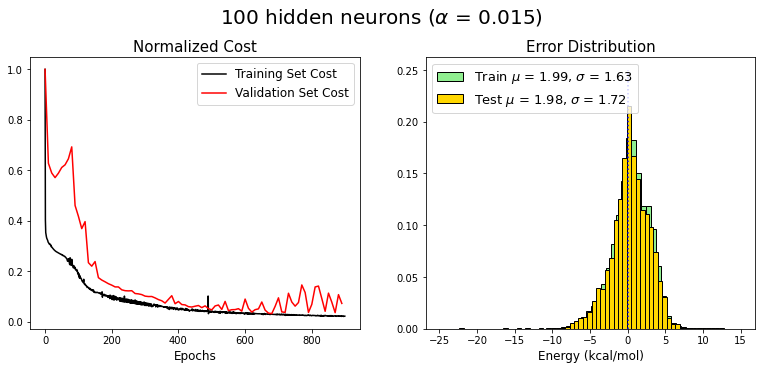

In [ ]:
result = np.load('M1_100.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'100 hidden neurons ($\alpha$ = 0.015)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,900,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M1_100_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13,loc='upper left')
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.25,ls=':',color='b')
print(kcal.min(),q.min())


In [ ]:
torch.manual_seed(75)
learning_rate = 0.004
epochs = 980
model_1_200 = Single_Hidden(15,200,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1_200.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_1_200, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_1_200(test_X),test_y).detach().numpy()
np.savez('M1_200',C=total_cost,V=cross_val)
torch.save(model_1_200,'M1_200_torch')

2.70353682897985
0.03042551316320896
-27.187397 0.0004412873


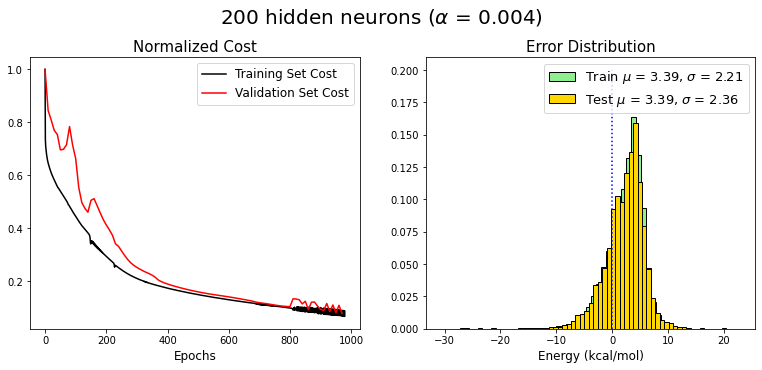

In [ ]:
result = np.load('M1_200.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'200 hidden neurons ($\alpha$ = 0.004)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M1_200_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13)
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.20,ls=':',color='b')
print(kcal.min(),q.min())

In [ ]:
class Double_Hidden(nn.Module):
  # Contructor
  def __init__(self, in_size=15, h1=100, h2=100, out_size=1):
    super(Double_Hidden, self).__init__()
    self.L_h1 = nn.Linear(in_size, h1)
    self.L_h2 = nn.Linear(h1, h2)
    self.L_out = nn.Linear(h2, out_size)
    
  # Prediction
  def forward(self, x):
    f = nn.Softplus()
    x = f(self.L_h1(x))
    x = f(self.L_h2(x))
    x = self.L_out(x)
    return x

In [ ]:
torch.manual_seed(12)
learning_rate = 0.0015
epochs = 980
model_2_50 = Double_Hidden(15,75,60,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2_50.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_2_50, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_2_50(test_X),test_y).detach().numpy()
np.savez('M2_50',C=total_cost,V=cross_val)
torch.save(model_2_50,'M2_50_torch')

3.874949734658003
0.04368692263960838
-40.955925 0.0042787804


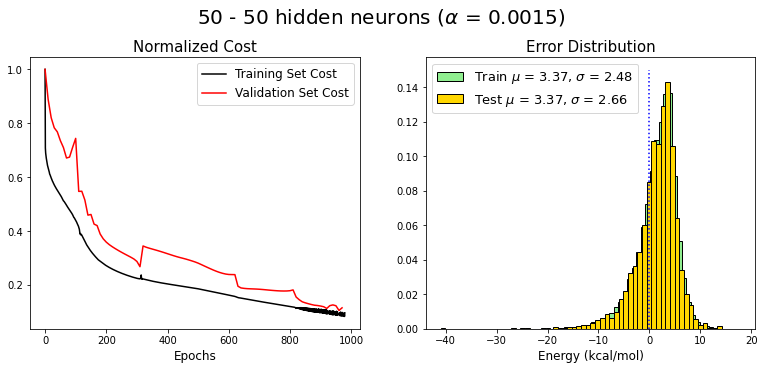

In [ ]:
result = np.load('M2_50.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'50 - 50 hidden neurons ($\alpha$ = 0.0015)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M2_50_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13)
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.15,ls=':',color='b')
print(kcal.min(),q.min())

In [ ]:
torch.manual_seed(9)
learning_rate = 0.0015
epochs = 980
model_2_200 = Double_Hidden(15,200,200,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2_200.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_2_200, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_2_200(test_X),test_y).detach().numpy()
np.savez('M2_200',C=total_cost,V=cross_val)
torch.save(model_2_200,'M2_200_torch')

1.0598014746792614
0.013038115575909615
-12.75446 0.00010727425


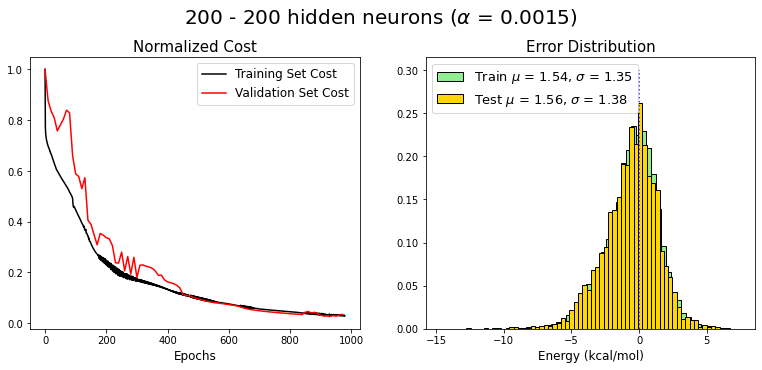

In [ ]:
result = np.load('M2_200.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'200 - 200 hidden neurons ($\alpha$ = 0.0015)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M2_200_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13,loc='upper left')
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.30,ls=':',color='b')
print(kcal.min(),q.min())

In [ ]:
class Four_Hidden(nn.Module):
  # Contructor
  def __init__(self, in_size=15, h1=100, h2=100, 
               h3=100, h4=100, out_size=1):
    super(Four_Hidden, self).__init__()
    self.L_h1 = nn.Linear(in_size, h1)
    self.L_h2 = nn.Linear(h1, h2)
    self.L_h3 = nn.Linear(h2, h3)
    self.L_h4 = nn.Linear(h3, h4)
    self.L_out = nn.Linear(h4, out_size)
    
  # Prediction
  def forward(self, x):
    f = nn.Softplus()
    x = f(self.L_h1(x))
    x = f(self.L_h2(x))
    x = f(self.L_h3(x))
    x = f(self.L_h4(x))
    x = self.L_out(x)
    return x

In [ ]:
torch.manual_seed(4)
learning_rate = 0.002
epochs = 980
model_4_50 = Four_Hidden(15,50,50,50,50,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_4_50.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_4_50, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_4_50(test_X),test_y).detach().numpy()
np.savez('M4_50',C=total_cost,V=cross_val)
torch.save(model_4_50,'M4_50_torch')

2.010446408763528
0.020640375092625618
-26.779732 2.6818563e-05


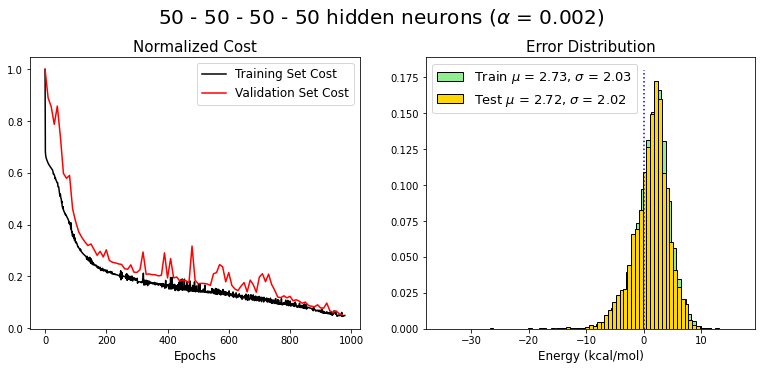

In [ ]:
result = np.load('M4_50.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'50 - 50 - 50 - 50 hidden neurons ($\alpha$ = 0.002)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M4_50_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label=r'Train $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label=r'Test $\mu$ = {:.2f}, $\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].vlines(0,0,0.18,ls=':',color='b')
print(kcal.min(),q.min())

In [ ]:
torch.manual_seed(32)
learning_rate = 0.001
epochs = 980
model_4_100 = Four_Hidden(15,100,100,100,100,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_4_100.parameters(), lr=learning_rate)
total_cost = np.zeros(epochs)
cross_val = np.zeros(epochs//10)
for e in range(epochs):
  cost_arr = batch_train(model_4_100, train_X, train_y, criterion, optimizer,80,512)
  total_cost[e] = cost_arr.sum()
  if not e % 10: cross_val[e//10] = criterion(model_4_100(test_X),test_y).detach().numpy()
np.savez('M4_100',C=total_cost,V=cross_val)
torch.save(model_4_100,'M4_100_torch')

1.3101423224434257
0.012639426626265049
-28.992485 0.0012921672


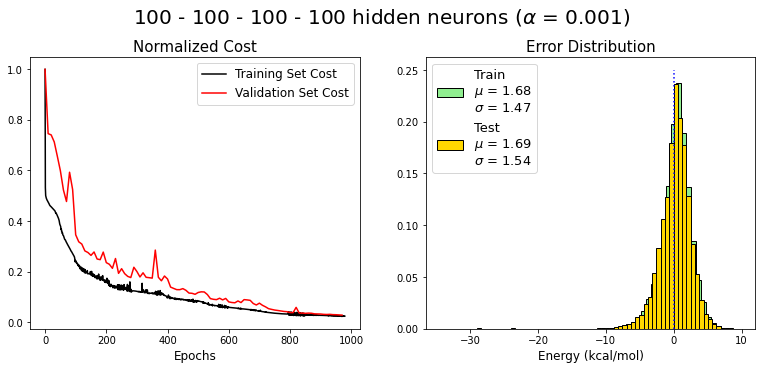

In [ ]:
result = np.load('M4_100.npz',allow_pickle=True)
fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'100 - 100 - 100 - 100 hidden neurons ($\alpha$ = 0.001)',fontsize=20,y=1.02)
ax[0].plot(result['C']/result['C'].max(),c='k',label='Training Set Cost')
ax[0].plot(np.arange(0,epochs,10),result['V']/result['V'].max(),c='r',label='Validation Set Cost')
ax[0].set_title('Normalized Cost',fontsize=15)
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Epochs',fontsize=12)
print(result['C'][-1])
print(result['V'][-1])
model = torch.load('M4_100_torch')
tk = (model(train_X) - train_y) * E_std * 23
tk = tk.view(1,-1).detach().numpy()[0]
w = np.abs(tk)
ax[1].hist(tk,bins=60,density=True,color='lightgreen',edgecolor='k',label='Train\n$\mu$ = {:.2f}\n$\sigma$ = {:.2f}'.format(w.mean(),w.std()))
kcal = (model(test_X) - test_y) * E_std * 23
kcal = kcal.view(1,-1).detach().numpy()[0]
q = np.abs(kcal)
ax[1].hist(kcal,bins=60,density=True,color='gold',edgecolor='k',label='Test\n$\mu$ = {:.2f}\n$\sigma$ = {:.2f}'.format(q.mean(),q.std()))
ax[1].legend(fontsize=13,loc='upper left')
ax[1].set_xlabel('Energy (kcal/mol)',fontsize=12)
ax[1].set_title('Error Distribution',fontsize=15)
ax[1].vlines(0,0,0.25,ls=':',color='b')
print(kcal.min(),q.min())

1.0546170155563095

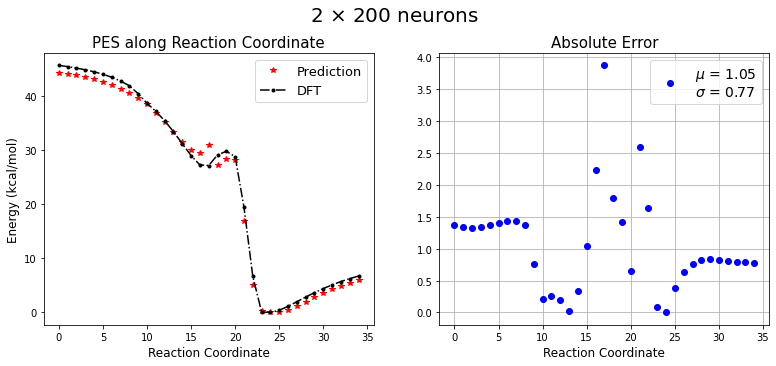

In [ ]:
pw_int = np.load('FCl_pathway_internal.npz',allow_pickle=True)
model = torch.load('M2_200_torch')
path_X = torch.from_numpy(pw_int['R']).view(-1,15).float()
kcal = model(path_X).detach().view(1,-1).numpy()[0]
kcal *= (23 * E_std)
kcal -= kcal.min()

fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'2 $\times$ 200 neurons',fontsize=20,y=1.01)
ax[0].plot(kcal,label='Prediction',ls='',marker='*',c='r')
ax[0].plot(pw_int['E'],label='DFT',marker='.',c='k',ls='-.')
ax[0].legend(fontsize=13)
ax[0].set_ylabel('Energy (kcal/mol)',fontsize=12)
ax[0].set_xlabel('Reaction Coordinate',fontsize=12)
ax[0].set_title('PES along Reaction Coordinate',fontsize=15)

deviations = np.abs(kcal - pw_int['E'])
ax[1].plot(deviations,ls='',marker='o',c='b',label='$\mu$ = {:.2f}\n$\sigma$ = {:.2f}'.format(deviations.mean(),deviations.std()))
ax[1].set_xlabel('Reaction Coordinate',fontsize=12)
ax[1].set_title('Absolute Error',fontsize=15)

ax[1].grid(); ax[1].legend(fontsize=14)
deviations.mean()

0.8414680637700199

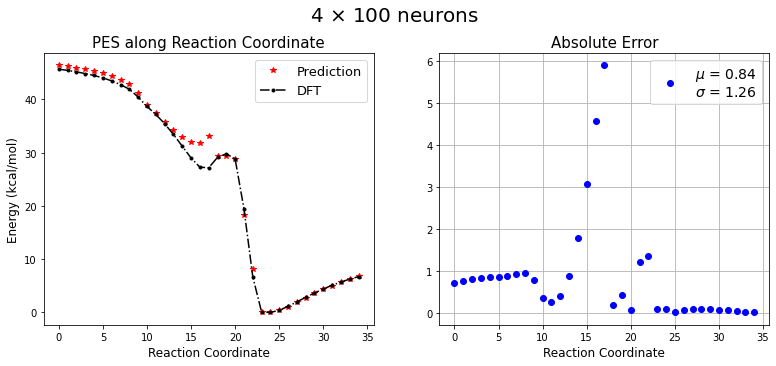

In [ ]:
pw_int = np.load('FCl_pathway_internal.npz',allow_pickle=True)
model = torch.load('M4_100_torch')
path_X = torch.from_numpy(pw_int['R']).view(-1,15).float()
kcal = model(path_X).detach().view(1,-1).numpy()[0]
kcal *= (23 * E_std)
kcal -= kcal.min()

fig, ax = plt.subplots(1,2,figsize=(13,5))
fig.suptitle(r'4 $\times$ 100 neurons',fontsize=20,y=1.01)
ax[0].plot(kcal,label='Prediction',ls='',marker='*',c='r')
ax[0].plot(pw_int['E'],label='DFT',marker='.',c='k',ls='-.')
ax[0].legend(fontsize=13)
ax[0].set_ylabel('Energy (kcal/mol)',fontsize=12)
ax[0].set_xlabel('Reaction Coordinate',fontsize=12)
ax[0].set_title('PES along Reaction Coordinate',fontsize=15)

deviations = np.abs(kcal - pw_int['E'])
ax[1].plot(deviations,ls='',marker='o',c='b',label='$\mu$ = {:.2f}\n$\sigma$ = {:.2f}'.format(deviations.mean(),deviations.std()))
ax[1].set_xlabel('Reaction Coordinate',fontsize=12)
ax[1].set_title('Absolute Error',fontsize=15)

ax[1].grid(); ax[1].legend(fontsize=14)
deviations.mean()

In [ ]:
for each in model.parameters():
  print(each.shape)

torch.Size([200, 15])
torch.Size([200])
torch.Size([1, 200])
torch.Size([1])


In [ ]:
data = np.load("sn2_reactions.npz")
# print contents to console
print("Contents:")
for key in data.keys():
  print(key, data[key].shape)
print()


Contents:
R (452709, 6, 3)
Q (452709,)
D (452709, 3)
E (452709,)
F (452709, 6, 3)
Z (452709, 6)
N (452709,)



In [ ]:
# as example for accessing individual entries, print the data for entry idx=0
idx = np.random.randint(0,data['Q'].size)
print("Data for entry " + str(idx)+":")
print("Number of atoms")
print(data["N"][idx])
print("Energy [eV]")
print(data["E"][idx])
print("Total charge")
print(data["Q"][idx])
print("Dipole moment vector (with respect to [0.0 0.0 0.0]) [eA]")
print(data["D"][idx,:])
print("Nuclear charges")
print(data["Z"][idx,:])
print("Cartesian coordinates [A]")
print(data["R"][idx,:data["N"][idx],:])
print("Forces [eV/A]")
print(data["F"][idx,:data["N"][idx],:])

Data for entry 129732:
Number of atoms
3
Energy [eV]
-4.385129141627631
Total charge
0.0
Dipole moment vector (with respect to [0.0 0.0 0.0]) [eA]
[ 3.38583455e-01 -6.73325083e-02  1.05835442e-05]
Nuclear charges
[ 6  1 17  0  0  0]
Cartesian coordinates [A]
[[-2.490680e-01  1.168989e+00 -5.000000e-06]
 [ 7.140680e-01  1.692919e+00  3.000000e-05]
 [ 4.590200e-02 -5.121680e-01  0.000000e+00]]
Forces [eV/A]
[[-7.53619704e-01 -4.27347717e-01 -2.77679162e-05]
 [ 5.01435602e-01 -4.33530192e-01  1.64550615e-05]
 [ 2.52393389e-01  8.59840211e-01  1.13128548e-05]]


In [ ]:
b1 = np.where((data["Z"] == a1).all(axis=1))
b2 = np.where((data["Z"] == a2).all(axis=1))
print(b1[0].size + b2[0].size)

44501


In [ ]:
np.savez('F-Cl',E=data["E"][b1],R=data["R"][b1],D=data["D"][b1])
np.savez('Cl-F',E=data["E"][b2],R=data["R"][b2],D=data["D"][b2])

In [ ]:
i = b1[0][25]
Num = data["N"][i]
print(Num)
print(f'Coordinates from Python E {data["E"][i]} eV ')
coord = data["R"][i,:,:]
a = data["Z"][i,:]
for j in range(6):
  
  print(f' {a[j]}   {coord[j,0]}   {coord[j,1]}   {coord[j,2]}')
print()

6
Coordinates from Python E -13.531029289560617 eV 
 6   0.000555   0.001168   -0.318196
 1   0.001581   1.046411   -0.073968
 1   -0.903653   -0.520596   -0.074205
 1   0.905891   -0.521827   -0.074201
 35   0.0003   -0.000607   -2.438414
 35   -0.000504   0.000293   2.499315



([<matplotlib.axis.YTick at 0x7fbc547676d0>,
 [Text(0, 0, 'C'),
  Text(0, 0, 'H'),
  Text(0, 0, 'H'),
  Text(0, 0, 'H'),
  Text(0, 0, 'F'),
  Text(0, 0, 'Cl')])

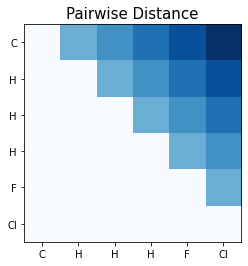

In [ ]:
a = np.zeros((6,6),int)
for i in range(5):
  for j in range(5-i): a[i][-j-1] = -i-j+8
plt.imshow(a,cmap='Blues')
an = ['C','H','H','H','F','Cl']
plt.title('Pairwise Distance',fontsize=15)
pos = np.arange(6)
plt.xticks(pos,an)
plt.yticks(pos,an)